In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(10)

def f(x):
    return 1 + x**2

def sampling(n_sample=500, scale=10):
    data = []
    X = scale * (np.random.random_sample(n_sample) - 0.5) # - 0.5 _ 0.5
    for i in range(n_sample):
        yi = f(X[i])
        data.append([X[i], yi])
#     data.append([X, y])
    return np.array(data)

def sample_Z(n_sample, n_dim):
    return np.random.uniform(-1., 1., size=[n_sample, n_dim])

In [2]:
data = sampling()
print(data.shape)

(500, 2)


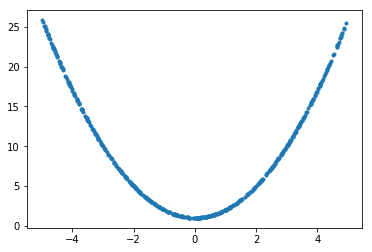

In [3]:
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.show()

In [4]:
hidden_size = 32

def GNet(Z, reuse=False):
    with tf.variable_scope("GNet", reuse=reuse):
        h1 = tf.layers.dense(Z, units=hidden_size, activation=tf.nn.relu)
        h2 = tf.layers.dense(h1, units=hidden_size, activation=tf.nn.relu)
        out = tf.layers.dense(h2, 2)
    return out

def DNet(X, reuse=False):
    with tf.variable_scope('DNet', reuse=reuse):
        h1 = tf.layers.dense(X, units=hidden_size, activation=tf.nn.relu)
        h2 = tf.layers.dense(h1, units=hidden_size, activation=tf.nn.relu)
        h3 = tf.layers.dense(h2, 2)
        out = tf.layers.dense(h3, 1)
        return out, h3

In [5]:
X = tf.placeholder(tf.float32, [None, 2], name="X")
Z = tf.placeholder(tf.float32, [None, 2], name="Z")

In [6]:
G_sample = GNet(Z)
r_logits, r_visual = DNet(X)
f_logits, f_visual = DNet(G_sample, reuse=True)

D_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='DNet')
G_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='GNet')

D_loss = -(tf.reduce_mean(r_logits) - tf.reduce_mean(f_logits))
G_loss = -tf.reduce_mean(f_logits)
clip_D = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_var]

D_step = tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=D_var)
G_step = tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=G_var)

init = tf.global_variables_initializer()

In [7]:
batch_size = 128
loss_G_list = []
loss_D_list = []


with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('./graphs/simple_gan', tf.get_default_graph())
    for i in range(100000):
        
        X_batch = sampling(n_sample=batch_size)
        Z_batch = sample_Z(batch_size, 2)
        _, loss_D, _ = sess.run([D_step, D_loss, clip_D], feed_dict={X: X_batch, Z: Z_batch})
        
        if i%2==0:
            Z_batch = sample_Z(batch_size, 2)
            _, loss_G = sess.run([G_step, G_loss], feed_dict={Z: Z_batch})
        
        if i%100==0:
            loss_G_list.append(loss_G)
            loss_D_list.append(loss_D)
            
        
        
        if i%5000==0:
            print("Iteration: %d\t G_loss: %.4f\t D_loss: %.4f"%(i, loss_G, loss_D))
        
    z_ = sample_Z(100, 2)
    data_ = sess.run(G_sample, feed_dict={Z: z_})

Iteration: 0	 G_loss: 0.0002	 D_loss: 0.0274
Iteration: 5000	 G_loss: 0.1038	 D_loss: -0.0152
Iteration: 10000	 G_loss: 0.0540	 D_loss: -0.0020
Iteration: 15000	 G_loss: 0.0204	 D_loss: -0.0018
Iteration: 20000	 G_loss: -0.0008	 D_loss: -0.0049
Iteration: 25000	 G_loss: -0.0165	 D_loss: -0.0014
Iteration: 30000	 G_loss: -0.0035	 D_loss: -0.0011
Iteration: 35000	 G_loss: -0.0036	 D_loss: 0.0001
Iteration: 40000	 G_loss: 0.0038	 D_loss: -0.0000
Iteration: 45000	 G_loss: 0.0025	 D_loss: 0.0001
Iteration: 50000	 G_loss: 0.0113	 D_loss: -0.0010
Iteration: 55000	 G_loss: -0.0005	 D_loss: -0.0007
Iteration: 60000	 G_loss: 0.0055	 D_loss: 0.0004
Iteration: 65000	 G_loss: 0.0126	 D_loss: 0.0000
Iteration: 70000	 G_loss: 0.0099	 D_loss: 0.0009
Iteration: 75000	 G_loss: 0.0072	 D_loss: -0.0005
Iteration: 80000	 G_loss: 0.0107	 D_loss: -0.0004
Iteration: 85000	 G_loss: 0.0034	 D_loss: -0.0001
Iteration: 90000	 G_loss: -0.0051	 D_loss: 0.0013
Iteration: 95000	 G_loss: 0.0018	 D_loss: -0.0000


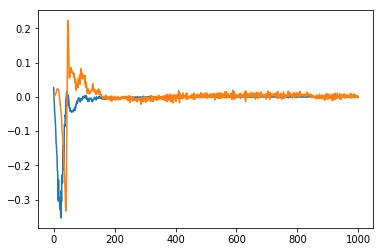

In [8]:
xplot = range(1000)
plt.plot(xplot, loss_D_list)
plt.plot(xplot, loss_G_list)
# plt.ylim([-.1, .1])
plt.show()

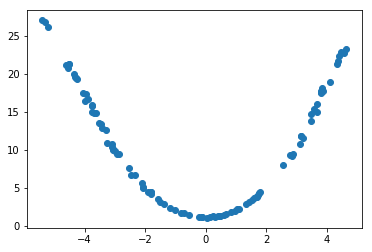

In [9]:
plt.scatter(data_[:, 0], data_[:, 1])
plt.show()